In [1]:
import torchvision.models as models
from torchvision.models.resnet import ResNet18_Weights
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import pandas as pd

In [2]:
resnet = models.resnet18(weights=ResNet18_Weights.IMAGENET1K_V1)
resnet.fc = nn.Flatten()

In [3]:
resnet

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

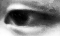

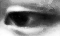

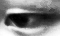

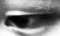

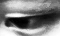

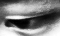

[None, None, None, None, None, None]

In [4]:
from zipfile import ZipFile
from PIL import Image
from glob import glob

image_list = []

subject_num = 20
batch_per_subject = 10

subject_list = np.repeat(np.arange(subject_num),batch_per_subject)

for data in glob("data/s*/synth/00[0-9]_left.zip"):

    with ZipFile(data) as archive:
        image_list.append([])
        for entry in archive.infolist():
            
            with archive.open(entry) as file:
                img = Image.open(file)
                image_list[-1].append(img)
                img.load()
                
list(map(display, image_list[0][-6:]))

In [5]:
gaze_list = []

for csv_file in glob("data/s*/synth/00[0-9]_left.csv"):
    gaze_list.append([])
    df = pd.read_csv(csv_file, header=None)
    gaze_list[-1].append(df[[0,1,2]].values)

gaze_list = np.array(gaze_list)

In [6]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet = resnet.to(device)
device

device(type='cuda', index=0)

In [7]:

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.225])
])

tensor_list = []

for image_group in image_list:
    image_tensor = [transform(i) for i in image_group]
    image_tensor = torch.cat(image_tensor).float()[:,None,...]
    image_tensor = image_tensor.repeat(1, 1, 3, 1, 1)
    tensor_list.append(image_tensor)
    
image_tensor = torch.concat(tensor_list)
image_tensor.shape

torch.Size([200, 144, 3, 36, 60])

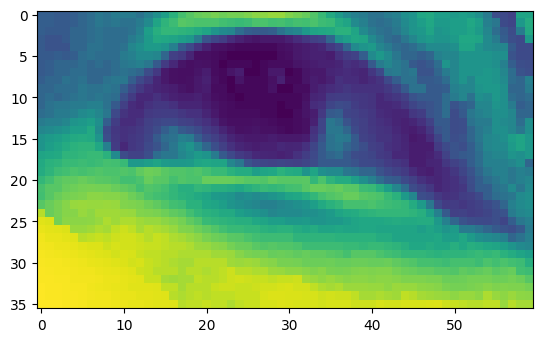

In [8]:
plt.imshow(image_tensor[0][0][0])

In [9]:
gaze_tensor = torch.concat([torch.tensor(i) for i in gaze_list]).float()
gaze_tensor.shape

torch.Size([200, 144, 3])

In [10]:
def pretrain(backbone):
    model = nn.Sequential(backbone, nn.Linear(512, 3)).to(device)
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    for epoch in range(1,  10):
        optimizer.zero_grad()
        for batch, gaze in zip(image_tensor, gaze_tensor):
            out = model(batch.to(device))
            loss = criterion(out, gaze.to(device))
            loss.backward()
            optimizer.step()
        print("Loss:", float(loss))

pretrain(resnet)

Loss: 9.33440113067627
Loss: 3.2306699752807617
Loss: 0.8472028970718384
Loss: 0.26576197147369385
Loss: 0.5216819047927856
Loss: 0.10656087845563889
Loss: 0.18742473423480988
Loss: 0.11015980690717697
Loss: 0.09027491509914398


In [11]:
def train(backbone, n_epochs, train_data, train_label, subject_list):
    backbone.train()
    sigma2 = 1
    SIGMA_u = torch.eye(512).to(device)
    
    fixed_effects = nn.Linear(512, 1, bias=False).to(device)
    
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(list(backbone.parameters()) + list(fixed_effects.parameters()))
    
    # Observation per batch
    n_i = train_data.shape[1]
    
    # Amount of batches
    n_batch = train_data.shape[0]
    
    # Amount of subjects
    n_sub = len(np.unique(subject_list))
    
    # Total of observations
    n = n_i * n_batch
    
    random_effects = [nn.Linear(512, 1, bias=False).to(device) for i in range(n_sub)]
    for coeff in random_effects:
        coeff.weight.data.fill_(0.0)
    
    I_n_i = torch.eye(n_i).to(device)
    for epoch in range(1, n_epochs + 1):
        
        # Train gamma & fixed effects
        fixed_effects.train()
        for i, batch in enumerate(train_data):
            optimizer.zero_grad()
            subject = subject_list[i]
            batch, y_i = batch.to(device), train_label[i].to(device)
            Gamma = backbone(batch)
            y_i_random = random_effects[subject](Gamma)
            y_i_fixed = y_i - y_i_random
            loss = criterion(fixed_effects(Gamma), y_i_fixed)
            loss.backward()
            optimizer.step()
            
        sigma2_sum = 0
        SIGMA_u_sum = 0
        backbone.eval()
        fixed_effects.eval()
        with torch.no_grad():
            for i, batch in enumerate(train_data):
                batch, y_i = batch.to(device), train_label[i].to(device)

                subject = subject_list[i]

                # E-Step

                Gamma = backbone(batch)
                y_i_fixed = fixed_effects(Gamma)

                V_i = Gamma @ SIGMA_u @ Gamma.T + (sigma2 * I_n_i)
                V_i_inv = torch.inverse(V_i)

                # U_i = random_effects.weight
                random_effects[subject].weight.data = (SIGMA_u @ Gamma.T @ V_i_inv @ (y_i - y_i_fixed)).T
                epsilon_i = y_i - y_i_fixed - random_effects[subject](Gamma)

                # M-step
                u_i = random_effects[subject].weight.data
                sigma2_sum += epsilon_i.T @ epsilon_i + sigma2 * (n_i - sigma2 * torch.trace(V_i_inv))
                SIGMA_u_sum += u_i.T @ u_i + (SIGMA_u - SIGMA_u @ Gamma.T @ V_i_inv @ Gamma @ SIGMA_u)

            sigma2 = sigma2_sum / n
            SIGMA_u = SIGMA_u_sum / n_batch

            loss_g = 0.0
        
            for i, batch in enumerate(train_data):
                batch, y_i = batch.to(device), train_label[i].to(device)
                subject = subject_list[i]
                Gamma = backbone(batch)
                y_i_fixed = fixed_effects(Gamma)
                y_i_random = random_effects[subject](Gamma)
                SIGMA_e = sigma2 * I_n_i
                u_i = random_effects[subject].weight.data.T
                error = y_i - y_i_fixed - y_i_random

                loss_g += float(error.T @ torch.inverse(SIGMA_e) @ error\
                         + u_i.T @ torch.inverse(SIGMA_u) @ u_i \
                         + torch.det(SIGMA_e) + torch.det(SIGMA_u))
        
        print("Epoch:", epoch, "LA LOSS ELLE VÔ", loss_g/n)
    
    return fixed_effects, random_effects

In [12]:
def random_effect_estimation(backbone, random_effects, train_data, subject_list):
    # backbone -> random_effects
    h = nn.Linear(512,1).to(device)
    h.train()
    backbone.eval()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(h.parameters())
    for epoch in range(5):
        for i, batch in enumerate(train_data):
            subject = subject_list[i]
            
            with torch.no_grad():
                X = backbone(batch.to(device))
                y = random_effects[subject](X)
            
            loss = criterion(h(X), y)
            loss.backward()
            optimizer.step()
    h.eval()
    return h

In [13]:
# Returns the angle between the two vectors
def angular_difference(truth_batch, pred_batch):
    diff = 0
    for truth, pred in zip(truth_batch, pred_batch):
        angle_val = torch.dot(pred, truth)
        angle_val = max(min(angle_val, 1), -1)
        diff += np.arccos(angle_val) * 180 / np.pi
    return diff / truth_batch.shape[0]

In [14]:
def cross_validation(backbone, image_tensor, gaze_tensor, fold = 3):
    
    n = gaze_tensor.shape[0] // fold * (fold-1)
    g_train = lambda x : gaze_tensor[:n, :, x, None]
    g_test = lambda x : gaze_tensor[n:, :, x, None]
    
    im_train = image_tensor[:n]
    im_test = image_tensor[n:]
    
    fixed_effects, random_effects = zip(*[train(backbone, 1, im_train, g_train(i), subject_list[:n]) for i in range(3)])
    
    backbone.eval()
    h = [random_effect_estimation(resnet, random_effects[i], im_train, subject_list[:n]) for i in range(3)]
    
    total_loss = 0.0
    
    with torch.no_grad():
        predict = torch.zeros(144, 3)
        for i, test in enumerate(im_test):
            Gamma = backbone(test.to(device))
            loss = 0.0
            
            truth = gaze_tensor[n:][i]
            for j in range(3):
                predict[:, j] = (fixed_effects[j](Gamma).cpu() + h[j](Gamma).cpu())[0]
                
            total_loss += angular_difference(truth, predict)
    return float(total_loss / im_test.shape[0])
        

In [15]:
torch.cuda.empty_cache()
cross_validation(resnet, image_tensor, gaze_tensor)

Epoch: 1 LA LOSS ELLE VÔ 1.6881727750855262
Epoch: 1 LA LOSS ELLE VÔ 1.2126080456255661
Epoch: 1 LA LOSS ELLE VÔ 0.333955050568388


13.205401420593262

In [16]:
def cross_validation_simple(backbone, image_tensor, gaze_tensor, fold = 3):
    
    n = gaze_tensor.shape[0] // fold * (fold-1)
    g_train = gaze_tensor[:n, :, :, None]
    g_test = gaze_tensor[n:, :, :, None]
    
    im_train = image_tensor[:n]
    im_test = image_tensor[n:]
    
    model = nn.Sequential(backbone, nn.Linear(512, 3)).to(device)
    backbone.train()
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters())
    for epoch in range(1,  10):
        optimizer.zero_grad()
        for batch, gaze in zip(im_train, gaze_tensor):
            out = model(batch.to(device))
            loss = criterion(out, gaze.to(device))
            loss.backward()
            optimizer.step()
    
    total_loss = 0.0
    backbone.eval()
    model.eval()
    
    with torch.no_grad():
        predict = torch.zeros(144, 3)
        for i, test in enumerate(im_test):
            predict = model(test.to(device)).cpu()
            
            truth = gaze_tensor[n:][i]
            total_loss += angular_difference(truth, predict)
    return float(total_loss / im_test.shape[0])

In [17]:
torch.cuda.empty_cache()
cross_validation_simple(resnet, image_tensor, gaze_tensor)

45.04079055786133